### Exploratory Data Analysis
1) Search for seasonality in energy generation
 - yearly (with temperature changes)
 - daily (with sun rise and set)
 - Look at moving average
      - day-to-day
      - year-to-year<br><br>

2) Examine more advanced metrics station-by-station
 - Autocorrelation
 - FFT<br><br> 

3) Choose _forward-chaining_ vs _sliding-window_ type analysis
 - sliding probably most realistic since it will utilize the least memory<br><br> 

4) Try out various models
 - fft model (statsmodels.tsa.models?)
 - ARIMA model (or just ARMA? or auto-ARIMA?)
 - __LSTM model - final choice__
     - __data is multivariate__
     - __LSTM takes into account recent context - encoder+decoder architecture__
         - encoder = recent context
         - decoder = prediction<br><br>

5) Create multi-layer model
 - First fit yearly trends with artificial function (sine + cosine) according to what looks best
 - Next fit daily trends (residuals of yearly) with another artificial function (sine + cosine) according to what looks best
 - Finally use all the available weather data to fit the final residuals (yearly and daily combined)<br><br>

6) Build a pipeline for this multi-layer model

### Notes on making final website:
 - use bootstrap
 - collection of templates for different html styles
 - bootstrap will help you produce containers for the elements in your webpage
 - find a website you like and appropriate their html code, adding elements as you like

In [1]:
# import libraries
import math
import pandas as pd
import numpy as np
import datetime as dt

# FFT to look for signals
from scipy import fftpack

# Import lstm packages
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Debugging
import pdb

# Plotting and displays
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot, lag_plot
from ipywidgets import interact, fixed
from IPython.display import display
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 14})

Using TensorFlow backend.


In [2]:
def load_data(filename):
    df = pd.read_csv(filename)
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d %H:%M:%S')
    df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H:%M:%S')
    df.set_index('datetime', inplace=True)
    return df

In [3]:
# load data
wthrdf = load_data('final_weather_data_2015to2018.csv').sort_values(['station_name', 'datetime'])
pwrdf = load_data('final_power_data_2015to2018.csv').sort_values(['station_name', 'datetime'])
pwrdf = pwrdf.drop(['hour'], axis=1)
pwrdf['hour'] = pwrdf.index.hour
pwrdf['day'] = pwrdf.index.day
pwrdf['month'] = pwrdf.index.month
pwrdf['year'] = pwrdf.index.year

In [314]:
display(wthrdf.head(3))
display(pwrdf.head(30))

,station_id,hour,temp,dew_point,pressure,wind_dir,wind_speed,date,weather_station_name,latitude,longitude,elevation,station_name,distance
datetime,,,,,,,,,,,,,,
2015-01-01 00:00:00,716210,1.0,19.4,6.8,101.77,260.0,10.2902,2015-01-01,TRENTON,44.117,-77.533,86.3,ADELAIDE,33.434798
2015-01-01 01:00:00,716210,1.0,19.4,6.8,101.77,260.0,10.2902,2015-01-01,TRENTON,44.117,-77.533,86.3,ADELAIDE,33.434798
2015-01-01 02:00:00,716210,2.0,21.2,6.8,101.65,270.0,13.8694,2015-01-01,TRENTON,44.117,-77.533,86.3,ADELAIDE,33.434798


,station_name,date,power_output,pred_power_output,max_power_output,pmax_power_output,pred_pmax_power_output,latitude,longitude,station_id,distance,hour,day,month,year
datetime,,,,,,,,,,,,,,,
2015-01-01 00:00:00,ADELAIDE,2015-01-01,58.0,57.0,59.0,0.983051,0.966102,43.100099,-81.634304,716210,33.434798,0,1,1,2015
2015-01-01 01:00:00,ADELAIDE,2015-01-01,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304,716210,33.434798,1,1,1,2015
2015-01-01 02:00:00,ADELAIDE,2015-01-01,56.0,55.0,59.0,0.949153,0.932203,43.100099,-81.634304,716210,33.434798,2,1,1,2015
2015-01-01 03:00:00,ADELAIDE,2015-01-01,58.0,57.0,59.0,0.983051,0.966102,43.100099,-81.634304,716210,33.434798,3,1,1,2015
2015-01-01 04:00:00,ADELAIDE,2015-01-01,58.0,58.0,59.0,0.983051,0.983051,43.100099,-81.634304,716210,33.434798,4,1,1,2015
2015-01-01 05:00:00,ADELAIDE,2015-01-01,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304,716210,33.434798,5,1,1,2015
2015-01-01 06:00:00,ADELAIDE,2015-01-01,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304,716210,33.434798,6,1,1,2015
2015-01-01 07:00:00,ADELAIDE,2015-01-01,57.0,57.0,59.0,0.966102,0.966102,43.100099,-81.634304,716210,33.434798,7,1,1,2015
2015-01-01 08:00:00,ADELAIDE,2015-01-01,59.0,58.0,59.0,1.000000,0.983051,43.100099,-81.634304,716210,33.434798,8,1,1,2015


In [5]:
# Look at predictions and models station-by-station
stations = list(pwrdf.groupby('station_name').count().index)
print(stations)
station = 'KINGSBRIDGE'

pwr_colnames = ['power_output','pred_power_output','pmax_power_output','pred_pmax_power_output']
wthr_colnames = ['temp','dew_point','pressure','wind_dir','wind_speed']

['ADELAIDE', 'AMARANTH', 'BLAKE', 'BORNISH', 'COMBER', 'DILLON', 'EAST LAKE', 'ERIEAU', 'GOSFIELDWGS', 'GRANDWF', 'JERICHO', 'KINGSBRIDGE', 'LANDON', 'PAROCHES', 'PORT BURWELL', 'PORTALMA-T1', 'PORTALMA-T3', 'RIPLEY SOUTH', 'SHANNON', 'SPENCE', 'SUMMERHAVEN', 'UNDERWOOD', 'WOLFE ISLAND']


In [6]:
def autoplot_alias(df, station, yvar, tspan='week', t=0):
    df = df.loc[df['station_name']==station, yvar]
    if tspan=='day':
        tsp = 1 * 24
    elif tspan=='week':
        tsp = 7 * 24
    elif tspan=='month':
        tsp = 30 * 24
    elif tspan=='year':
        tsp = 365*24
    else:
        return 'error'
    autocorrelation_plot(df[tsp*t:tsp*(t+1)]) # 1 week worth of data, we'll be able to scroll through weeks

In [7]:
# day-by-day analysis
interact(autoplot_alias,\
         df=fixed(pwrdf),\
         station=fixed(station),\
         yvar=fixed('pmax_power_output'),\
         tspan=fixed('day'),\
         t = (0,10,1));

interactive(children=(IntSlider(value=0, description='t', max=10), Output()), _dom_classes=('widget-interact',…

In [8]:
# year by year analysis
interact(autoplot_alias,\
         df=fixed(pwrdf),\
         station=fixed(station),\
         yvar=fixed('pmax_power_output'),\
         tspan=fixed('year'),\
         t = (0,3,1));

interactive(children=(IntSlider(value=0, description='t', max=3), Output()), _dom_classes=('widget-interact',)…

In [131]:
def yearly_avg(df, yvar, station):
    df = df.loc[df['station_name']==station]
    start_date  = dt.datetime(2018, 4, 19)
    dist = df.loc[start_date,'distance']
    
    # visualize yearly average
    avg_df = pd.DataFrame(df[yvar].groupby([(df.index.month),(df.index.day)]).mean())
    newindex = pd.DataFrame(avg_df.index.values)
    newindex['datetime'] = ['2019-' + '%02d' % x + '-' + '%02d' % y for x, y in newindex.loc[:,0]]
    avg_df.set_index(newindex['datetime'], inplace=True)
    avg_df.reset_index(inplace=True)

    # calculate moving average as well (average over 2 weeks or 14 days)
    mvavg_df = pd.DataFrame(avg_df[yvar].rolling(14).mean())
    mvavg_df.set_index(newindex['datetime'], inplace=True)
    mvavg_df.reset_index(inplace=True)

    # clean up stupid leap year days and datetime columns
    avg_df = avg_df.loc[avg_df['datetime']!='2019-02-29',:]
    avg_df['datetime'] = pd.to_datetime(avg_df['datetime'], format = '%Y-%m-%d')
    mvavg_df = mvavg_df.loc[mvavg_df['datetime']!='2019-02-29',:]
    mvavg_df['datetime'] = pd.to_datetime(mvavg_df['datetime'], format = '%Y-%m-%d')

    # plot avg and moving average of the average
    fig,ax = plt.subplots(figsize=(10,4))
    sns.lineplot(x="datetime", y=yvar, data=avg_df, label='4-year avg', color='#3498db');
    sns.lineplot(x="datetime", y=yvar, data=mvavg_df, label= 'moving avg', color='#e74c3c', ax=ax);
    ax.set_title('Data for wind farm: ' + station + ' (' + str(int(round(dist,0))) + ' miles from weather station)')
    ax.set_xlabel('Date')
    plt.xticks(rotation=45)
    ax.legend();

In [132]:
interact(yearly_avg,\
         df = fixed(pwrdf),\
         yvar = pwr_colnames,\
         station = stations);

interactive(children=(Dropdown(description='yvar', options=('power_output', 'pred_power_output', 'pmax_power_o…

In [11]:
interact(yearly_avg,\
         df = fixed(wthrdf),\
         yvar = wthr_colnames,\
         station = stations);

interactive(children=(Dropdown(description='yvar', options=('temp', 'dew_point', 'pressure', 'wind_dir', 'wind…

In [12]:
def daily_avg(df, yvar, station):
    df = df.loc[df['station_name']==station]
    
    # visualize yearly average
    avg_df = pd.DataFrame(df[yvar].groupby([(df.index.hour)]).mean())
    newindex = pd.DataFrame(avg_df.index.values)
    newindex['datetime'] = ['2019-01-01 ' + '%02d' % x + ':00:00' for x in newindex.loc[:,0]]
    avg_df.set_index(newindex['datetime'], inplace=True)
    avg_df.reset_index(inplace=True)

    # calculate moving average as well (average over 2 weeks or 14 days)
    mvavg_df = pd.DataFrame(avg_df[yvar].rolling(2).mean())
    mvavg_df.set_index(newindex['datetime'], inplace=True)
    mvavg_df.reset_index(inplace=True)

    # clean up datetime columns
    avg_df['datetime'] = pd.to_datetime(avg_df['datetime'], format = '%Y-%m-%d %H:%M:%S')
    mvavg_df['datetime'] = pd.to_datetime(mvavg_df['datetime'], format = '%Y-%m-%d %H:%M:%S')

    # plot avg and moving average of the average
    fig,ax = plt.subplots(figsize=(6,4))
    sns.lineplot(x="datetime", y=yvar, data=avg_df, label='4-year avg', color='#3498db');
    sns.lineplot(x="datetime", y=yvar, data=mvavg_df, label= 'moving avg', color='#e74c3c', ax=ax);
    ax.set_title('Data for wind farm: ' + station)
    ax.set_xlabel('Date')
    plt.xticks(rotation=45)
    ax.legend();

In [13]:
interact(daily_avg,\
         df = fixed(pwrdf),\
         yvar = pwr_colnames,\
         station = stations);

interactive(children=(Dropdown(description='yvar', options=('power_output', 'pred_power_output', 'pmax_power_o…

In [14]:
interact(daily_avg,\
         df=fixed(wthrdf),\
         yvar=wthr_colnames,\
         station = stations);

interactive(children=(Dropdown(description='yvar', options=('temp', 'dew_point', 'pressure', 'wind_dir', 'wind…

In [15]:
# Find most promissing dataset by wind_speed-wind_power correlation
for station in stations:
    X = wthrdf.loc[wthrdf['station_name']==station, 'wind_speed']
    X[X>60] = 60
    y = pwrdf.loc[pwrdf['station_name']==station, 'pmax_power_output']
    y[y>1] = 1
    cc = np.corrcoef(X,y)
    cc = str(round(cc[0,1], 3))
    print(station + ' '*(20-len(station)) + 'R\u00B2 = ' + cc)
    
    # look at some subsets of the data
    train_interval = 7*24*2 # 2 week training dataset
    for i in range(100):    
        cut1 = i * train_interval # start idx of training dataset
        cut2 = (i + 1) * train_interval # end index of training dataset (and start index of test dataset)
        X_sub = X[cut1:cut2]
        y_sub = y[cut1:cut2]
        cc_sub = np.corrcoef(X_sub,y_sub)
        cc_sub = str(round(cc_sub[0,1], 3))
        print(' '*(20) + 'R\u00B2 = ' + cc_sub + '\t  ' + str(len(np.unique(X_sub))) + '\t  ' + str(len(np.unique(y_sub))))

ADELAIDE            R² = 0.181
                    R² = 0.5	  23	  60
                    R² = 0.16	  20	  59
                    R² = 0.049	  20	  60
                    R² = 0.081	  20	  57
                    R² = 0.109	  23	  58
                    R² = 0.093	  21	  58
                    R² = -0.047	  21	  59
                    R² = -0.0	  1	  57
                    R² = 0.136	  15	  57
                    R² = 0.207	  21	  57
                    R² = -0.1	  18	  58
                    R² = -0.032	  15	  56
                    R² = 0.103	  19	  54
                    R² = 0.178	  16	  48
                    R² = 0.225	  16	  48
                    R² = 0.235	  16	  46
                    R² = 0.269	  17	  50
                    R² = 0.094	  14	  40
                    R² = 0.283	  16	  47
                    R² = 0.59	  18	  53
                    R² = 0.166	  19	  53
                    R² = 0.131	  24	  58
                    R² = 0.328	  23	  58
                    R² = 0.062	

BLAKE               R² = 0.182
                    R² = 0.463	  23	  57
                    R² = 0.092	  20	  58
                    R² = -0.025	  20	  59
                    R² = 0.121	  20	  59
                    R² = 0.183	  23	  60
                    R² = 0.043	  21	  60
                    R² = -0.076	  21	  59
                    R² = -0.0	  1	  58
                    R² = 0.213	  15	  56
                    R² = 0.251	  21	  57
                    R² = -0.034	  18	  56
                    R² = -0.071	  15	  53
                    R² = -0.012	  19	  51
                    R² = 0.134	  16	  45
                    R² = 0.096	  16	  45
                    R² = -0.071	  16	  53
                    R² = 0.272	  17	  59
                    R² = 0.166	  14	  44
                    R² = 0.164	  16	  50
                    R² = 0.566	  18	  58
                    R² = 0.152	  19	  59
                    R² = 0.205	  24	  57
                    R² = 0.244	  23	  58
                    R²

COMBER              R² = 0.536
                    R² = 0.62	  19	  122
                    R² = -0.373	  5	  113
                    R² = -0.179	  8	  136
                    R² = -0.048	  9	  123
                    R² = -0.087	  5	  117
                    R² = -0.196	  12	  134
                    R² = 0.389	  20	  135
                    R² = 0.0	  1	  128
                    R² = 0.395	  13	  115
                    R² = 0.614	  20	  113
                    R² = 0.545	  17	  130
                    R² = 0.375	  17	  102
                    R² = 0.603	  18	  99
                    R² = 0.516	  12	  81
                    R² = 0.479	  13	  79
                    R² = 0.479	  16	  93
                    R² = 0.594	  17	  96
                    R² = 0.386	  12	  65
                    R² = 0.392	  12	  96
                    R² = 0.672	  15	  118
                    R² = 0.622	  16	  141
                    R² = 0.573	  23	  118
                    R² = 0.595	  28	  128
             

C:\Users\alacroix367\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\alacroix367\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


EAST LAKE           R² = 0.543
                    R² = 0.645	  23	  85
                    R² = 0.674	  22	  89
                    R² = 0.317	  18	  95
                    R² = 0.44	  21	  87
                    R² = 0.468	  19	  88
                    R² = 0.397	  20	  91
                    R² = 0.416	  21	  87
                    R² = nan	  1	  88
                    R² = 0.337	  18	  86
                    R² = 0.576	  17	  82
                    R² = 0.526	  23	  86
                    R² = 0.368	  19	  80
                    R² = 0.558	  16	  75
                    R² = 0.496	  13	  65
                    R² = 0.507	  14	  58
                    R² = 0.375	  15	  64
                    R² = 0.62	  16	  76
                    R² = 0.393	  13	  46
                    R² = 0.197	  13	  68
                    R² = 0.431	  15	  82
                    R² = 0.549	  21	  91
                    R² = 0.704	  25	  89
                    R² = 0.706	  25	  90
                    R² = 0.621	

GOSFIELDWGS         R² = 0.487
                    R² = 0.606	  19	  50
                    R² = -0.331	  5	  49
                    R² = -0.169	  8	  50
                    R² = -0.142	  9	  51
                    R² = -0.093	  5	  50
                    R² = -0.195	  12	  50
                    R² = 0.363	  20	  48
                    R² = -0.0	  1	  49
                    R² = 0.377	  13	  43
                    R² = 0.594	  20	  46
                    R² = 0.529	  17	  50
                    R² = 0.37	  17	  45
                    R² = 0.561	  18	  44
                    R² = 0.502	  12	  39
                    R² = 0.466	  13	  35
                    R² = 0.539	  16	  40
                    R² = 0.531	  17	  40
                    R² = 0.392	  12	  27
                    R² = 0.376	  12	  39
                    R² = 0.683	  15	  48
                    R² = 0.625	  16	  51
                    R² = 0.571	  23	  49
                    R² = 0.571	  28	  50
                    R² = 0.6

JERICHO             R² = 0.259
                    R² = 0.481	  24	  101
                    R² = 0.392	  24	  84
                    R² = 0.208	  63	  118
                    R² = 0.496	  71	  124
                    R² = 0.218	  70	  118
                    R² = 0.316	  69	  116
                    R² = 0.509	  73	  119
                    R² = -0.0	  1	  122
                    R² = 0.212	  49	  113
                    R² = 0.148	  66	  111
                    R² = 0.13	  68	  112
                    R² = 0.213	  58	  104
                    R² = 0.056	  55	  104
                    R² = 0.413	  56	  79
                    R² = 0.393	  61	  87
                    R² = 0.284	  55	  74
                    R² = 0.444	  60	  96
                    R² = 0.241	  48	  75
                    R² = 0.233	  50	  105
                    R² = 0.535	  52	  107
                    R² = 0.219	  46	  114
                    R² = 0.406	  52	  127
                    R² = 0.192	  56	  111
            

LANDON              R² = 0.113
                    R² = 0.143	  21	  169
                    R² = 0.184	  22	  20
                    R² = -0.063	  21	  37
                    R² = 0.009	  19	  39
                    R² = 0.258	  20	  41
                    R² = -0.084	  21	  41
                    R² = 0.066	  20	  41
                    R² = 0.0	  1	  41
                    R² = 0.255	  17	  39
                    R² = 0.132	  20	  37
                    R² = -0.032	  22	  39
                    R² = -0.09	  16	  39
                    R² = 0.032	  17	  40
                    R² = 0.204	  16	  37
                    R² = 0.064	  15	  36
                    R² = 0.111	  16	  37
                    R² = 0.142	  15	  35
                    R² = 0.117	  13	  36
                    R² = 0.057	  13	  33
                    R² = 0.423	  18	  41
                    R² = 0.146	  18	  41
                    R² = -0.232	  26	  40
                    R² = 0.249	  20	  39
                    R² =

                    R² = 0.429	  21	  64
                    R² = 0.509	  21	  66
                    R² = 0.331	  14	  37
                    R² = 0.329	  18	  61
                    R² = 0.678	  23	  80
                    R² = 0.497	  21	  86
                    R² = 0.73	  24	  79
                    R² = 0.339	  26	  66
                    R² = 0.469	  28	  74
                    R² = 0.418	  22	  69
                    R² = 0.386	  27	  91
                    R² = 0.476	  24	  106
                    R² = 0.535	  25	  91
                    R² = 0.525	  22	  90
                    R² = 0.171	  26	  72
                    R² = 0.215	  26	  56
                    R² = 0.148	  24	  108
                    R² = 0.227	  24	  77
                    R² = 0.289	  20	  65
                    R² = 0.164	  19	  42
                    R² = 0.354	  22	  66
                    R² = 0.135	  20	  36
                    R² = 0.147	  21	  55
                    R² = 0.478	  23	  71
               

RIPLEY SOUTH        R² = 0.471
                    R² = 0.671	  30	  70
                    R² = 0.389	  23	  71
                    R² = 0.409	  25	  77
                    R² = 0.499	  26	  74
                    R² = 0.314	  17	  67
                    R² = 0.362	  23	  69
                    R² = 0.273	  24	  52
                    R² = nan	  1	  68
                    R² = 0.47	  16	  46
                    R² = 0.277	  19	  49
                    R² = 0.266	  21	  56
                    R² = 0.435	  22	  52
                    R² = 0.508	  19	  57
                    R² = 0.486	  16	  40
                    R² = 0.406	  15	  45
                    R² = 0.193	  19	  48
                    R² = 0.465	  19	  56
                    R² = 0.34	  16	  39
                    R² = 0.523	  21	  53
                    R² = 0.559	  20	  60
                    R² = 0.345	  23	  55
                    R² = 0.615	  29	  49
                    R² = 0.297	  29	  59
                    R² = 0.465	

SPENCE              R² = 0.394
                    R² = 0.493	  23	  89
                    R² = 0.489	  22	  76
                    R² = 0.485	  18	  92
                    R² = 0.67	  21	  91
                    R² = 0.511	  19	  80
                    R² = 0.31	  20	  86
                    R² = 0.356	  21	  91
                    R² = nan	  1	  88
                    R² = 0.346	  18	  76
                    R² = 0.425	  17	  61
                    R² = 0.518	  23	  70
                    R² = 0.296	  19	  67
                    R² = 0.518	  16	  68
                    R² = 0.449	  13	  50
                    R² = 0.452	  14	  58
                    R² = 0.13	  15	  65
                    R² = 0.482	  16	  69
                    R² = 0.401	  13	  44
                    R² = 0.142	  13	  67
                    R² = 0.588	  15	  90
                    R² = 0.326	  21	  86
                    R² = 0.668	  25	  92
                    R² = 0.281	  25	  72
                    R² = 0.425	 

UNDERWOOD           R² = 0.434
                    R² = 0.647	  18	  138
                    R² = 0.493	  16	  128
                    R² = 0.406	  16	  138
                    R² = 0.561	  19	  137
                    R² = 0.229	  17	  138
                    R² = 0.332	  19	  130
                    R² = 0.429	  19	  123
                    R² = 0.0	  1	  144
                    R² = 0.435	  13	  100
                    R² = 0.345	  15	  95
                    R² = 0.213	  16	  103
                    R² = 0.406	  17	  91
                    R² = 0.514	  16	  92
                    R² = 0.147	  12	  69
                    R² = 0.229	  12	  94
                    R² = 0.01	  15	  87
                    R² = 0.406	  13	  113
                    R² = 0.22	  12	  73
                    R² = 0.495	  17	  103
                    R² = 0.569	  18	  112
                    R² = 0.395	  19	  135
                    R² = 0.551	  16	  143
                    R² = 0.591	  19	  127
               

#### 1st make data stationary
 - at yearly timescales that we see seasonality
 - at daily timescales that we see seasonality

In [ ]:
# fit sin + cos to fit yearly seasonality

# fit sin + cos to fit daily seasonality

#### 2nd fit LSTM to stationary time series to predict hour-by-hour variability
Very helpful Uber overview [video](https://www.youtube.com/watch?v=bn8rVBuIcFg)
 - Note: use sliding window to minimize computational time
 - 1st test 
     - test dataset is perfectly forecasted data (perfect predictors)
     - calculate model performance as a function of forecast length (longer = forecast more distant/further out events)
     - compare to naiive forecast (tomorrow = mean(today))
 - 2nd test
     - test dataset is forecasted data + noise (adding uncertainty to the forecasted predictors)
     - calculate model performance as a function of forecast length (longer = forecast more distant/further out events)
     - compare to naiive forecast (tomorrow = mean(today))
 - 3rd test (most realistic combo)
     - test dataset is forecasted data + noise (which increases as a function of time)
     - calculate model performance as a function of forecast length (longer = forecast more distant/further out events)
     - compare to naiive forecast (tomorrow = mean(today))
     

Think about trying to make __prediction confidence intervals__

In [200]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import clone, BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [17]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names):
        self._feature_names = feature_names
    
    def fit(self, X, y=None):
        return self # nothing else to do here

    def transform(self, X, y=None):
        X = X.loc[:, self._feature_names]
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)
        return X # return the features of interest, still in a df, even if a single column

In [18]:
#Custom Transformer that just reshapes the ouptut of a previous transformer
class QuickReshape(BaseEstimator, TransformerMixin):

    def __init__( self, h_past, h_fut, style, order, shifted = False ):
        self.h_past = h_past
        self.h_fut = h_fut
        self.style = style
        self.order = order
        if shifted:
            self.shift = h_fut
        else:
            self.shift = 0
    
    def fit(self, X, y=None):
        return self # nothing else to do here

    def transform(self, X, y=None):
        # figure out which way to transform the data
        if self.style == 'lag':
            off = self.h_past-self.shift
        elif self.style == 'fut':
            off = self.h_fut
                        
        n_features = X.shape[1]//off
        
        return X.reshape((X.shape[0], off, n_features), order = self.order)

In [19]:
#### Custom Transformer ####
# Creates a numpy.array with lag predictors from any dataset
#   - starting h_past hours ago
class TimeTransform(BaseEstimator, TransformerMixin):

    def __init__( self, h_past, h_fut, style, shifted = False ):
        self.h_past = h_past
        self.h_fut = h_fut
        self.style = style
        if shifted:
            self.shift = h_fut
        else:
            self.shift = 0
    
    def fit( self, X, y = None ):
        return self
    
    def transform( self, X, y = None ):
        # figure out which way to transform the data
        if self.style == 'lag':
            off = self.h_past - self.shift
            correction = self.h_fut + self.shift
            fut_offset = self.shift
        elif self.style == 'fut':
            off = self.h_fut
            correction = self.h_past
            fut_offset = self.h_past
                
        # initialize empty matrix to which offset variables will be concatenated
        n_features = np.shape(X)[1]
        offset_vars = np.empty((len(X) - off - correction + 1, 0))
        if isinstance(X,pd.DataFrame):
            X = X.values
        for col in range(n_features):
            nooff = X[:, col]
            nrows = len(nooff) - off - correction + 1
            offset = np.empty((0, ))
            for n in range(off):
                start = n + fut_offset
                end = nrows + n + fut_offset
                offset = np.concatenate((offset, nooff[start:end]), axis=0)
            offset = np.reshape(offset, (nrows, off), order='F')
            offset_vars = np.concatenate((offset_vars, offset), axis=1)
        return offset_vars


In [20]:
wthrfeats = ['station_name', 'wind_speed', 'wind_dir', 'temp', 'dew_point', 'pressure', 'latitude', 'longitude', 'elevation']
pwrfeats = ['station_name', 'hour', 'day', 'month', 'year', 'pmax_power_output']
df1 = pwrdf.loc[:, pwrfeats].reset_index().rename(columns={'datetime':'datetime_pwr', 'station_name':'station_name_pwr'})
df2 = wthrdf.loc[:, wthrfeats].reset_index().rename(columns={'datetime':'datetime_wthr', 'station_name':'station_name_wthr'})
df = df1.join(df2).drop(['datetime_wthr','station_name_wthr'], axis=1).rename(columns={'datetime_pwr':'datetime', 'station_name_pwr':'station_name'})
display(df.head(5))
display(df.dtypes)

,datetime,station_name,hour,day,month,year,pmax_power_output,wind_speed,wind_dir,temp,dew_point,pressure,latitude,longitude,elevation
0,2015-01-01 00:00:00,ADELAIDE,0,1,1,2015,0.983051,10.2902,260.0,19.4,6.8,101.77,44.117,-77.533,86.3
1,2015-01-01 01:00:00,ADELAIDE,1,1,1,2015,0.966102,10.2902,260.0,19.4,6.8,101.77,44.117,-77.533,86.3
2,2015-01-01 02:00:00,ADELAIDE,2,1,1,2015,0.949153,13.8694,270.0,21.2,6.8,101.65,44.117,-77.533,86.3
3,2015-01-01 03:00:00,ADELAIDE,3,1,1,2015,0.983051,20.8041,260.0,23.0,6.8,101.53,44.117,-77.533,86.3
4,2015-01-01 04:00:00,ADELAIDE,4,1,1,2015,0.983051,20.8041,250.0,23.0,6.8,101.42,44.117,-77.533,86.3


datetime             datetime64[ns]
station_name                 object
hour                          int64
day                           int64
month                         int64
year                          int64
pmax_power_output           float64
wind_speed                  float64
wind_dir                    float64
temp                        float64
dew_point                   float64
pressure                    float64
latitude                    float64
longitude                   float64
elevation                   float64
dtype: object

## LSTM Model Development Pipeline

#### Notes on LSTM model development ###
 - use [this](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/) if I need no data predictions
 - avoid over or under fitting model ([link1](https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/), [link2](https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/))

#### Notes on compile (precompute step)
 - Perhaps the most commonly used optimization algorithms because of their generally better performance are:
   - Stochastic Gradient Descent, or `sgd`, that requires the tuning of a learning rate and momentum
   - ADAM, or `adam`, that requires the tuning of learning rate
   - RMSprop, or `rmsprop`, that requires the tuning of learning rate
 - e.g. `algorithm = SGD(lr=0.1, momentum=0.3)`

### 1) Parameters and model structure

In [1]:
# define parameters dictating model structure
station = 'KINGSBRIDGE'
yvar = 'pmax_power_output'
nlags = 168+24 # for both wthr and pwr datasets we have data for the past 24 hours
nfuts = 168 # for just wthr for which we have forecasts n futs hours in advance

# features to use in prediction
power_features = ['pmax_power_output']
weather_features = ['wind_speed'] # could include: 'temp', 'dew_point', 'pressure'
categorical_features = ['hour'] # could include: 'month', 'wind_dir'

# pre-define training and testing dfs for future use in pipelines:
training_df = df.loc[(df['year'] < 2018) & (df['station_name'] == station), :]
tmp_testing_df = df.loc[(df['year'] >= 2018) & (df['station_name'] == station), :]
# must add nlags from training dataset onto testing dataset in order to make predictions of the first point in the test dataset
testing_df = pd.concat((training_df[-(nlags+nfuts):], tmp_testing_df), axis = 0)

# check what we're working with in terms of input-output
display(StandardScaler().fit_transform(training_df[['pmax_power_output', 'wind_speed', 'temp']].values)[:8])
print(len(training_df))

NameError: name 'df' is not defined

In [415]:
# Define features and steps in power_pipeline
power_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( power_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag' ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'F' ) ) ] )

In [416]:
# Define features and steps in the past_weather_pipeline
past_weather_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( weather_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag', shifted = True ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'F', shifted = True ) ) ] )

# Define features and steps in the future_weather_pipeline
future_weather_pipeline = Pipeline( steps = [
    ( 'feature_selector', FeatureSelector( weather_features ) ),
    ( 'standard_scaler', StandardScaler( ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'fut' ) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'fut', order = 'F' ) ) ] )

# FeatureUnion past and future weather
weather_union = FeatureUnion( transformer_list = [
    ( 'past_weather_pipeline', past_weather_pipeline ),
    ( 'future_weather_pipeline', future_weather_pipeline ) ] )

In [417]:
# Define features and steps in the past_categorical_pipeline 
past_categorical_pipeline = Pipeline( steps = [
    ( 'cat_selector', FeatureSelector( categorical_features ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'lag', shifted = True ) ),
    ( 'one_hot_encoder', OneHotEncoder( categories = 'auto', sparse = False) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'lag', order = 'C', shifted = True ) ) ] )

# Define features and steps in the future_categorical_pipeline 
future_categorical_pipeline = Pipeline( steps = [
    ( 'cat_selector', FeatureSelector( categorical_features ) ),
    ( 'time_transformer', TimeTransform( h_past = nlags, h_fut = nfuts, style = 'fut' ) ),
    ( 'one_hot_encoder', OneHotEncoder( categories = 'auto', sparse = False) ),
    ( 'quick_reshape', QuickReshape( h_past = nlags, h_fut = nfuts, style = 'fut', order = 'C' ) ) ] )

# FeatureUnion past and future categorical features
categorical_union = FeatureUnion( transformer_list = [
    ( 'past_categorical_pipeline', past_categorical_pipeline ),
    ( 'future_categorical_pipeline', future_categorical_pipeline ) ] )

### 2) Create training and testing datasets

In [418]:
# functions to split data into training and testing
def train_test(df, nlags, nfuts, yvar):
    # X (features)
    d1 = power_pipeline.fit_transform(df)
    d2 = weather_union.fit_transform(df)
    d3 = categorical_union.fit_transform(df)
    X = np.concatenate((d1, d2, d3), axis=2)
    
    # y (predicted)
    SS = StandardScaler()
    y = df.loc[:, yvar].values
    y = SS.fit_transform(y.reshape(-1, 1))
    y = y[nlags + nfuts - 1:]
    return X, y, SS

In [419]:
# split data into training and testing subsets
X_train, y_train, SS_train = train_test(training_df, nlags, nfuts, yvar)
X_test, y_test, SS_test = train_test(testing_df, nlags, nfuts, yvar)

# triple checking X and y are the same shape and appropriately aligned
n_features = np.shape(X_train)[2]
print('dimension\ttrain\ttest\texpected')
print(' nlags  \t ' + str(np.shape(X_train)[1]) + '\t ' + str(np.shape(X_test)[1]) + '\t   ' + str(nlags))
print(' n_feats\t ' + str(np.shape(X_train)[2]) + '\t ' + str(np.shape(X_test)[2]) + '\t   ' + str(n_features))
print(' X_rows \t' + str(np.shape(X_train)[0]) + '\t' + str(np.shape(X_test)[0]))
print(' y_rows \t' + str(np.shape(y_train)[0]) + '\t' + str(np.shape(y_test)[0]))
# for i in range(5):
#     print(X_train[i])
#     print(y_train[i])

dimension	train	test	expected
 nlags  	 192	 192	   192
 n_feats	 26	 26	   26
 X_rows 	25945	8761
 y_rows 	25945	8761


### 3) Construct and initialize LSTM model

In [4]:
# use these tools to avoid overfitting
checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/keras_example.hdf5',
                                               monitor='val_loss',
                                               verbose=1, save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                              verbose=1, min_delta=.01)
tensorboard = keras.callbacks.TensorBoard(log_dir='./tb/Graph_Keras_01', 
                                         histogram_freq=0, 
                                         write_graph=True, 
                                         write_images=True)

history = model.fit(X_train, y_train_hot,
                    epochs=100,
                    batch_size=30,
                    validation_data=(X_test, y_test_hot),
                    callbacks=[checkpointer, earlystopping, tensorboard] )

In [2]:
# Define LSTM model and hyperparameters (could add more LSTM and Dense Layers to increase model complexity)
LSTM_units = 50
alpha = 2.5 * 10 ** -7
rate = 0.2

model = Sequential()
model.add(LSTM(LSTM_units, return_sequences = True, input_shape=(nlags, n_features))) # 24 timesteps and 29 features
model.add(keras.layers.Dropout(rate))
model.add(Dense(1), kernel_regularizer=regularizers.l2(alpha))

model.add(LSTM(LSTM_units))
model.add(keras.layers.Dropout(rate))
model.add(Dense(1), kernel_regularizer=regularizers.l2(alpha))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=168, epochs=5, verbose=1, shuffle=True, validation_data=(X_test, y_test))

NameError: name 'Sequential' is not defined

1905
(8592,)
(8592,)
(8592,)


interactive(children=(IntSlider(value=26, description='week', max=52), Output()), _dom_classes=('widget-intera…

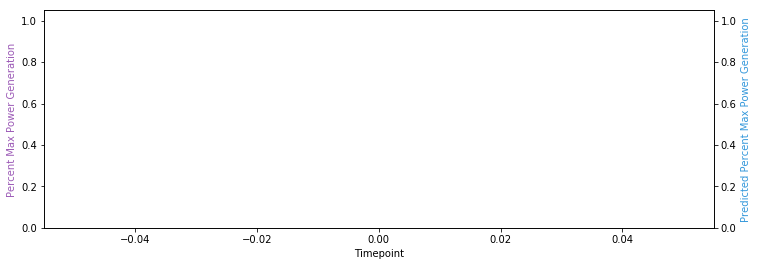

In [422]:
# evaluate predictions n-days out
# 1) of model
y_pred = model.predict(X_test)
y_pred = np.reshape(y_pred,(len(y_pred), ))
y_pred = SS_test.inverse_transform(y_pred) # recover initial values
y_pred = y_pred[1:]

# 2) of naiive prediction where next day = mean(previous 24hrs)
y_pred_naiive = X_test[:,-nfuts-1,0]
y_pred_naiive = y_pred_naiive[1:]
y_pred_naiive = SS_test.inverse_transform(y_pred_naiive) # recover initial values

# 3) actual values
y_true = tmp_testing_df.loc[:, yvar].values
# y_true = y_true[:-(nfuts+nlags-1) if nfuts>1 else None]

# 4) Fix nfuts offset:
# rolling avg on Xtest is computing the t+1 datapoint
# y_pred and y_true correspond to t+nfuts
y_pred = y_pred[:-nfuts]
y_pred_naiive = y_pred_naiive[nfuts:]
y_true = y_true[:-nfuts]

# 5) not trying to predict zero values (when the company itself just shuts off power from wind farms)
zeros = y_true==0
print(sum(zeros))
y_pred[zeros] =  0
y_pred_naiive[zeros] = 0

# triple check that our predictions all have the same length
print(np.shape(y_pred))
print(np.shape(y_pred_naiive))
print(np.shape(y_true))

# create prediction dataframe for evaluation
time = np.linspace(0,len(y_pred),len(y_pred))
resultsdf = pd.DataFrame({
    'time': time,
    'actual': y_true,
    'predicted': y_pred,
    'naiive_predicted': y_pred_naiive})

def view_results(df, week):
    # Create fig
    f,ax = plt.subplots(figsize=(12,4))
    df_subset = df.iloc[168*week:168*(week+1),:]

    sns.lineplot(x='time', y='actual', data=df_subset, color="#9b59b6") # purple
    ax2 = plt.twinx()
    sns.lineplot(x='time', y='predicted', data=df_subset, color="#3498db", ax=ax2) # blue
#     sns.lineplot(x='time', y='naiive_predicted', data=df_subset, color="#95a5a6", ax=ax2) # grey

    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Percent Max Power Generation', color="#9b59b6")
    ax2.set_ylabel('Predicted Percent Max Power Generation', color="#3498db")
    ax.set_ylim([0, 1.05])
    ax2.set_ylim([0, 1.05])

    r2model_full = r2_score(df.loc[df['actual']!=0, 'actual'], df.loc[df['predicted']!=0, 'predicted'].values)
    r2naiive_full = r2_score(df.loc[df['actual']!=0, 'actual'], df.loc[df['actual']!=0, 'naiive_predicted'].values)
    
    r2model_sub = r2_score(df_subset.loc[df_subset['actual']!=0, 'actual'], df_subset.loc[df_subset['predicted']!=0, 'predicted'].values)
    r2naiive_sub = r2_score(df_subset.loc[df_subset['actual']!=0, 'actual'], df_subset.loc[df_subset['actual']!=0, 'naiive_predicted'].values)

    ax.set_title('Full Dataset:  Model error = ' + str(round(r2model_full, 4)) + ', Naiive error = ' + str(round(r2naiive_full, 4)) + \
                 '\nSubset Dataset:  Model error = ' + str(round(r2model_sub, 4)) + ', Naiive error = ' + str(round(r2naiive_sub, 4)) + '   ')
    plt.show();

# Interactive visualization week-to-week
interact(view_results,\
         df = fixed(resultsdf),\
         week = (0,52,1));